<a href="https://colab.research.google.com/github/ronaldiscool/VAETutorial/blob/master/VAEtoy2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Typical VAEs
This notebook is a walk-through of the code to produce the results in Section 6. First, let us see what our ground truth datasets look like. 

Entropy for 8gaussians: -1.916776
Entropy for Checkerboard: -1.000000
Entropy for 2spirals: -2.335824


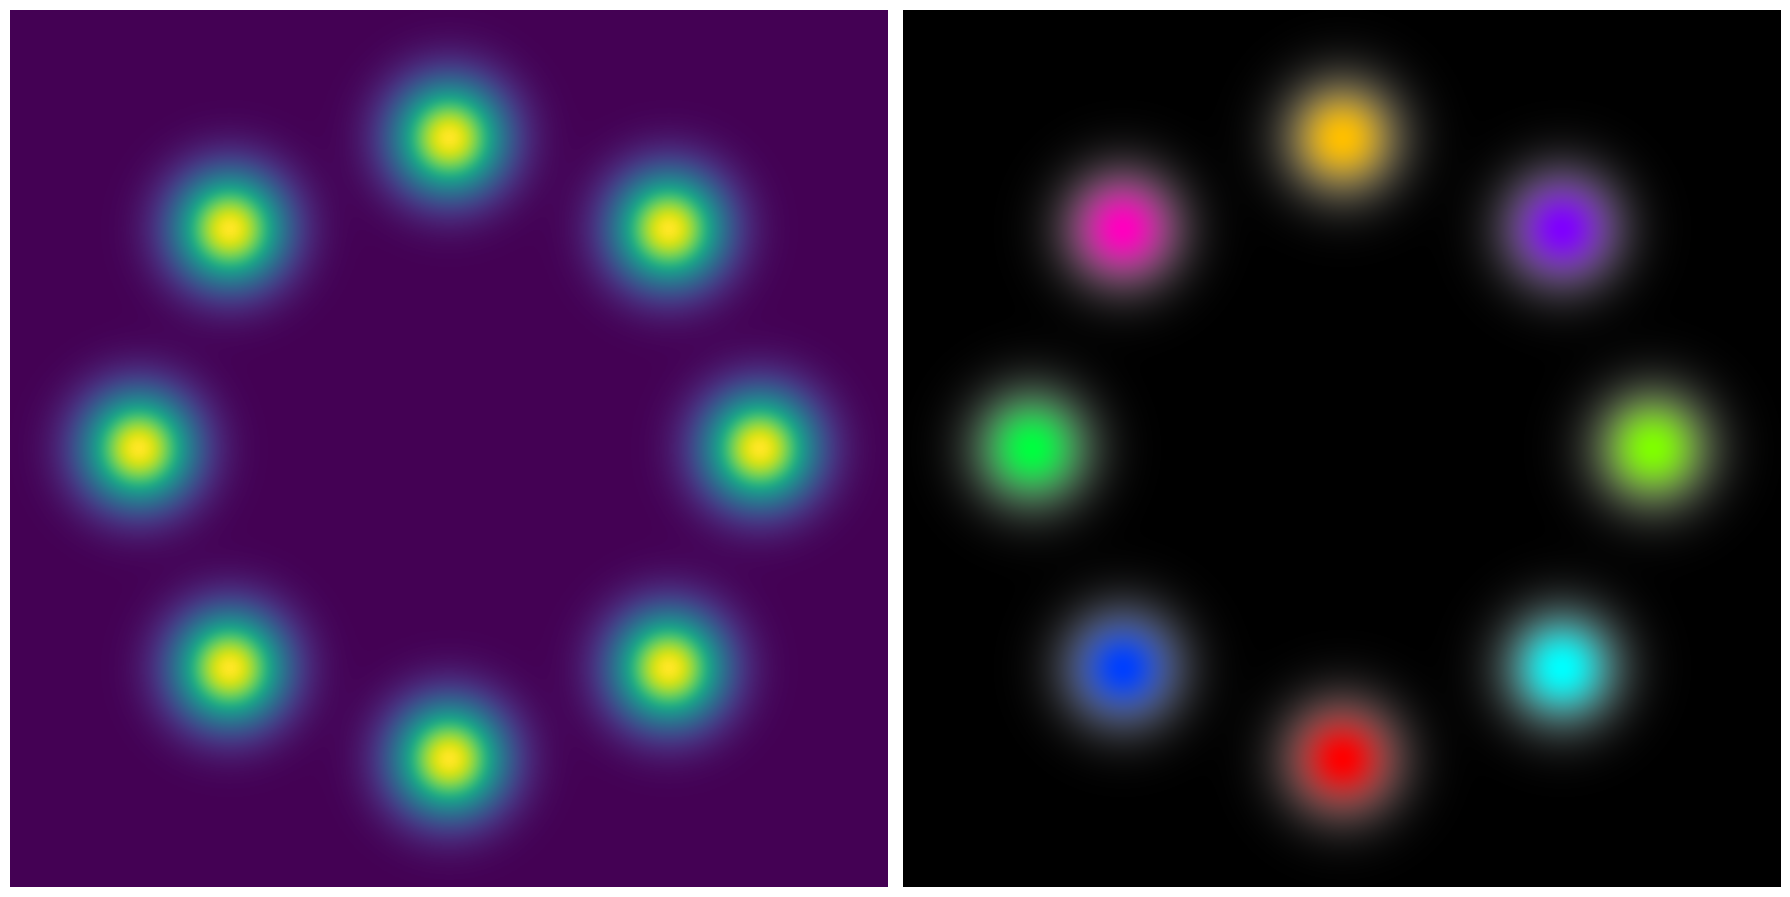

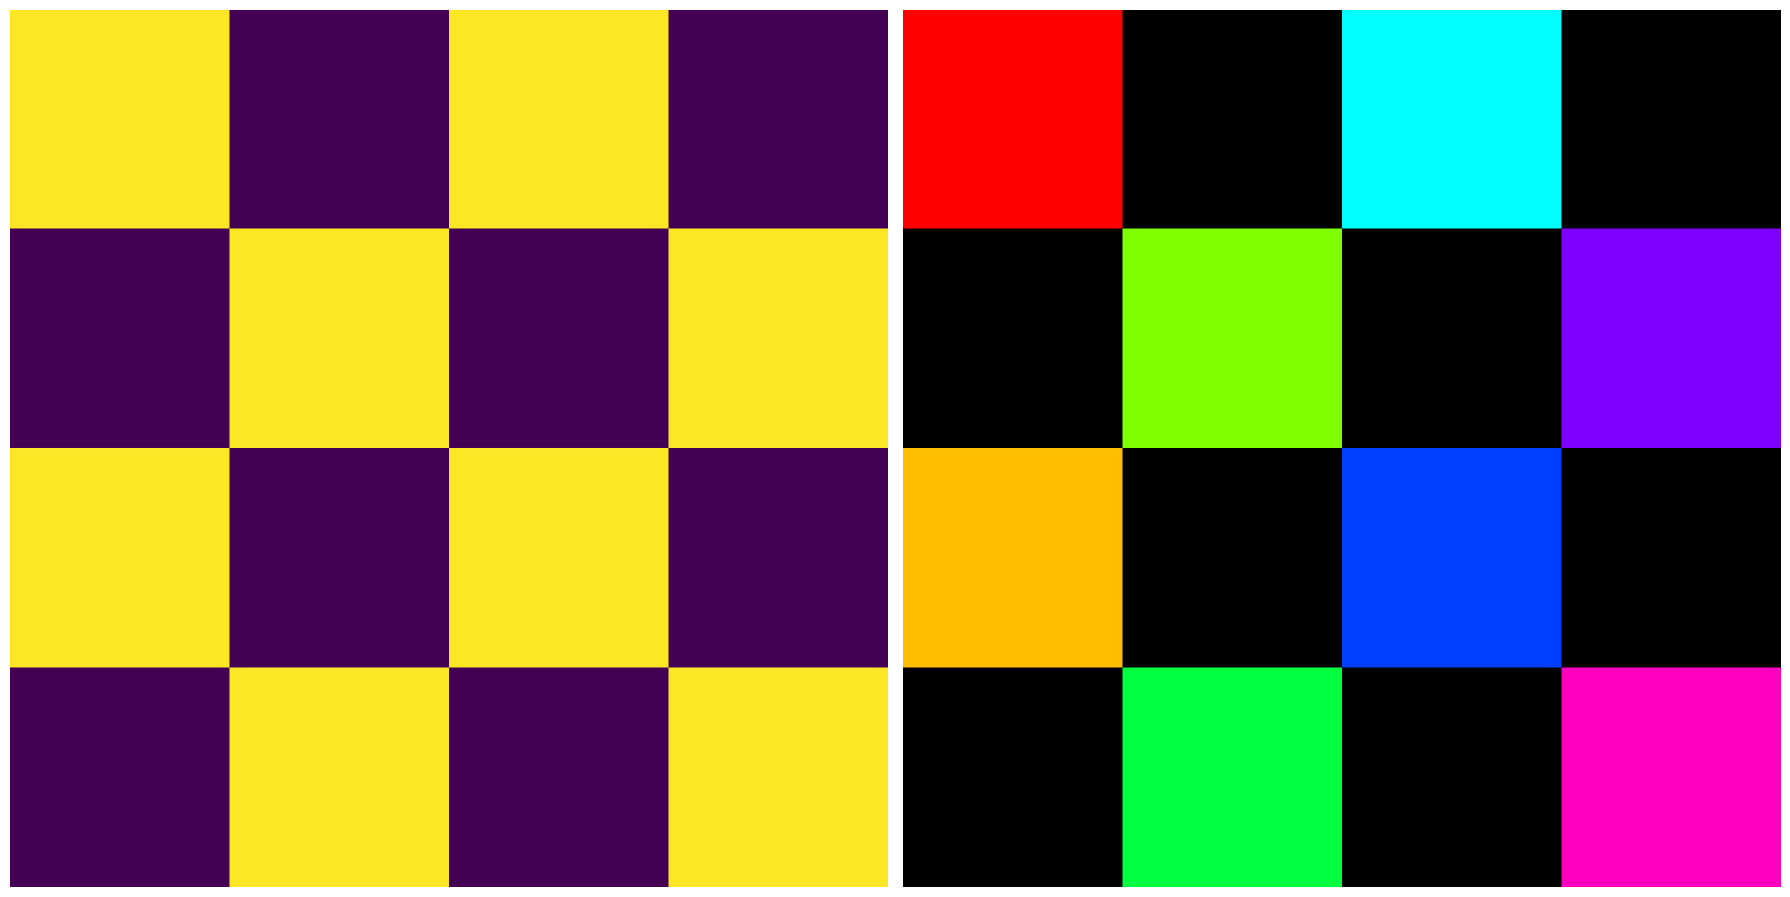

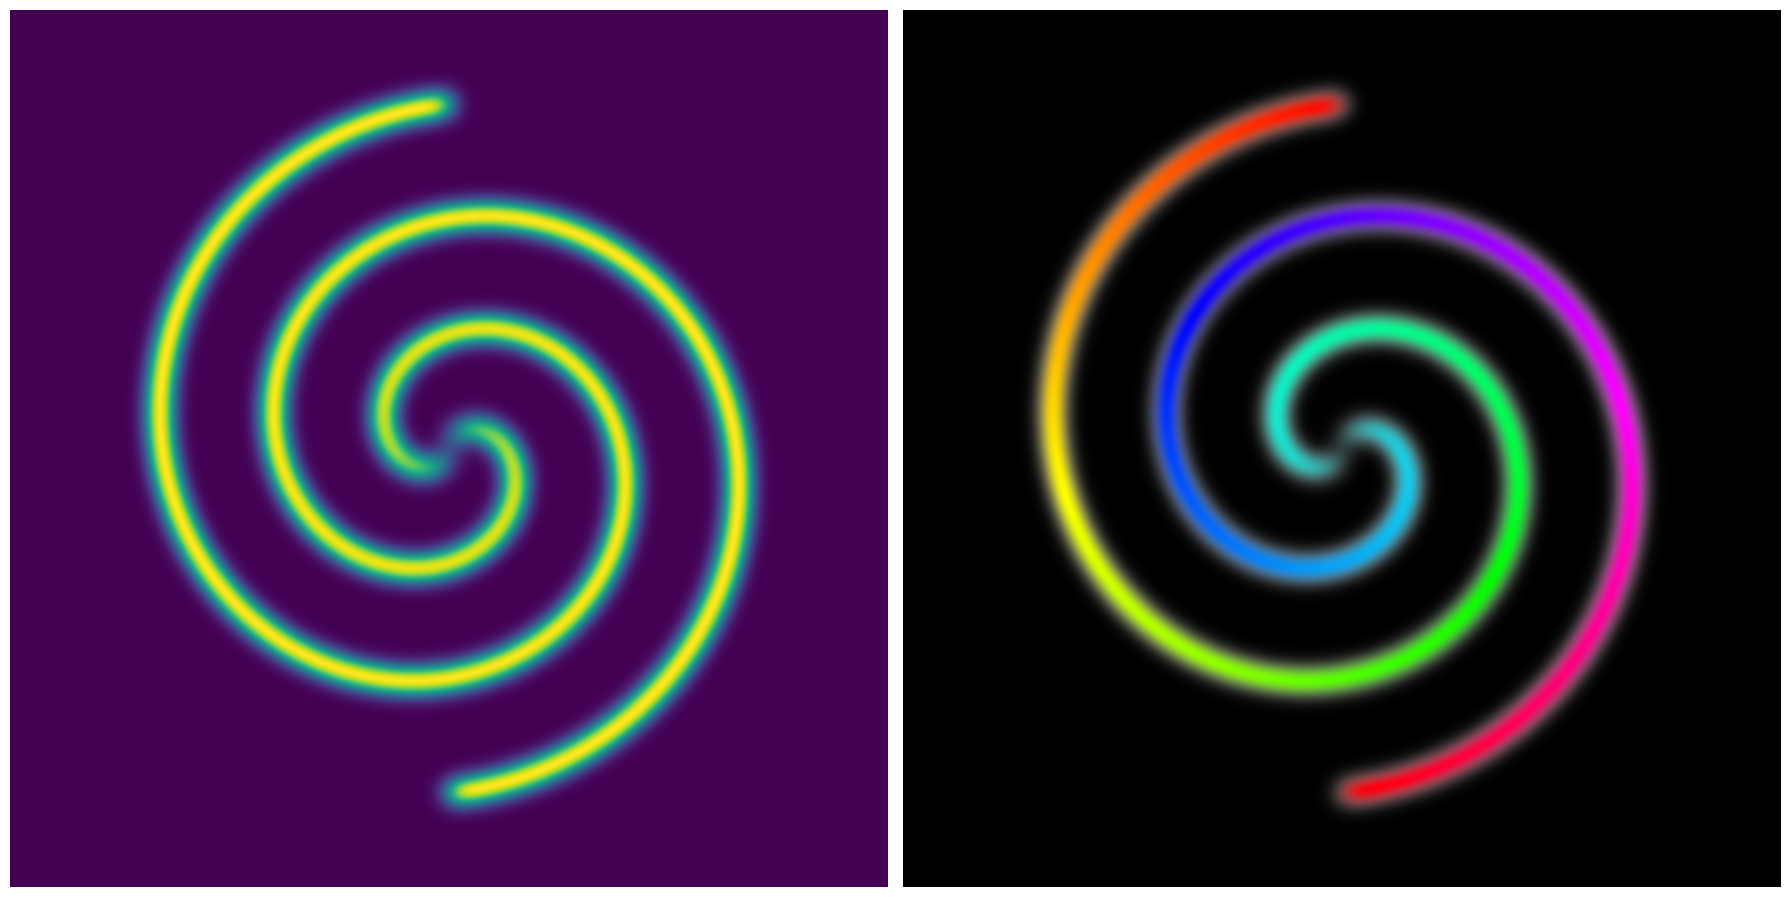

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col

def plot_gt(data):
    limit = 0.5
    step = 1/1024.0
    pixels = int(2*limit/step)
    grid = np.array([[a, b] for a in np.arange(-limit, limit, step) for b in np.arange(-limit, limit, step)])

    if data =='8gaussians':
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
               (1. / np.sqrt(2), -1. / np.sqrt(2)), (-1. / np.sqrt(2),
                                                     1. / np.sqrt(2)), (-1. / np.sqrt(2), -1. / np.sqrt(2))]
        centers = [(limit * x, limit * y) for x, y in centers]
        color = np.zeros((pixels*pixels,3))
        for i,center  in enumerate(centers):
            x = grid*1.414 - center
            prob = np.prod(1/(2*np.pi/256.0)**0.5 * np.exp(-x**2/(2/256.0)),-1)
            color[:,0] += i/8.0 * prob
            color[:,2] += prob 
    elif data =='checkerboard':
        l=[0,2,1,3,0,2,1,3]
        color = np.zeros((pixels,pixels,3))
        for i in range(8):
            y=i//2*256
            x=l[i]*256
            color[x:x+256, y:y+256,0]=i/8.0
            color[x:x+256, y:y+256,2]=1
    elif data=='2spirals':
        grid = grid.reshape((pixels,pixels,2))
        color = np.zeros((pixels,pixels,3))
        for i in range(10000):
            n = (i/10000.0)**0.5 * 540 * 2 *np.pi / 360
            d = np.zeros((1,2))
            d[0,0] = -np.cos(n) * n/3.0/8
            d[0,1] = np.sin(n) *  n /3.0 /8

            idx = int((d[0,0]+limit)/step)
            idy = int((d[0,1]+limit)/step)
            x = grid[idx-50:idx+50, idy-50:idy+50,:] - d
            cur_prob = np.prod(1/(2*np.pi*0.01/64)**0.5 * np.exp(-x**2/(2*0.01/64)),-1)

            cur_color = np.ones((100,100,3))
            cur_color[:,:,0] = (i/20000.0+0.5)*cur_prob
            cur_color[:,:,2] = cur_prob
            color[idx-50:idx+50, idy-50:idy+50] += cur_color

            #other spiral
            idx = int((-d[0,0]+limit)/step)
            idy = int((-d[0,1]+limit)/step)
            x = grid[idx-50:idx+50, idy-50:idy+50,:] + d
            cur_prob = np.prod(1/(2*np.pi*0.01/64)**0.5 * np.exp(-x**2/(2*0.01/64)),-1)
         
            cur_color = np.ones((100,100,3))
            cur_color[:,:,0] = (-i/20000.0+0.5)*cur_prob
            cur_color[:,:,2] = cur_prob
            color[idx-50:idx+50, idy-50:idy+50] += cur_color

        
    color = color.reshape((pixels,pixels,3))
    color[:,:,0]/=(color[:,:,2]+1e-12)
    color[:,:,1]=1
    prob = color[:,:,2].reshape((pixels,pixels))
    prob = prob / np.sum(prob) #normalize the data
    prob+=1e-20
    entropy = - prob * np.log(prob)/np.log(2)
    entropy = np.sum(entropy)
    max_prob = np.max(prob)

    color[:,:,2]/=np.max(color[:,:,2])
    color[:,:,1]=color[:,:,2]
    color = np.clip(color, 0, 1)
    color = col.hsv_to_rgb(color)


    fig = plt.figure(figsize=(18, 18))

    ax1 = fig.add_subplot(1,2,1)
    ax1.axis('off')
    ax1.imshow(prob, extent=(-limit, limit, -limit, limit))

    ax2 = fig.add_subplot(1,2,2)
    ax2.axis('off')
    ax2.imshow(color, extent=(-limit, limit, -limit, limit))

    fig.tight_layout()

    return entropy-20, max_prob, prob, color

entropy8g, max_prob8g, prob8g, color8g = plot_gt('8gaussians')
print('Entropy for 8gaussians: {:f}'.format( entropy8g))
#print('Max probability for 8gaussians: {:e}'.format(max_prob8g))

entropyc, max_probc, probc, colorc =plot_gt('checkerboard')
print('Entropy for Checkerboard: {:f}'.format( entropyc))
#print('Max probability for Checkerboard: {:e}'.format(max_probc))

entropy2s, max_prob2s, prob2s, color2s =plot_gt('2spirals')
print('Entropy for 2spirals: {:f}'.format( entropy2s))
#print('Max probability for 2spirals: {:e}'.format(max_prob2s))


We have plotted two figures for each dataset.
On the left-hand side is the ground truth density function. On the right-hand side is a color map of the data that we will later use to visualize the latent space of a VAE. 

We have also printed out the approximate entropy *H* of the ground truth probability distribution over the pixels. Recall that for continuous data, *H + 2n* can be interpreted as the number of bits needed to describe a sample from a 2D distribution to *n*-bit accuracy. As a sanity check, a uniform distribution across the whole domain should have an entropy of 0 bits, and the checkerboard dataset, which is a uniform distribution over half the domain, would have an entropy of -1. The entropy is also the value of the optimal negative log-likelihood for a maximum likelihood model.

Now let us set up the dataloader. We will call ```sample2d``` every iteration during training to sample a batch of continuous values from the ground truth dataset to train the VAE.

In [2]:
def sample2d(data, batch_size=200):
    #code largely taken from https://github.com/nicola-decao/BNAF/blob/master/data/generate2d.py

    rng = np.random.RandomState()

    if data == '8gaussians':
        scale = 4
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
                   (1. / np.sqrt(2), -1. / np.sqrt(2)), (-1. / np.sqrt(2),
                                                         1. / np.sqrt(2)), (-1. / np.sqrt(2), -1. / np.sqrt(2))]
        centers = [(scale * x, scale * y) for x, y in centers]

        dataset = []
        #dataset = np.zeros((batch_size, 2))
        for i in range(batch_size):
            point = rng.randn(2) * 0.5
            idx = rng.randint(8)
            center = centers[idx]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
            #dataset[i]=point
        dataset = np.array(dataset, dtype='float32')
        dataset /= 1.414
        return dataset/8.0

    elif data == '2spirals':
        n = np.sqrt(np.random.rand(batch_size, 1)) * 540 * (2 * np.pi) / 360
        d1x = -np.cos(n) * n
        d1y = np.sin(n) * n 
        x = np.hstack((d1x, d1y)) / 3 * (np.random.randint(0, 2, (batch_size,1)) * 2 -1)
        x += np.random.randn(*x.shape) * 0.1
        return x/8.0

    elif data == 'checkerboard':
        x1 = np.random.rand(batch_size) * 4 - 2
        x2_ = np.random.rand(batch_size) - np.random.randint(0, 2, batch_size) * 2
        x2 = x2_ + (np.floor(x1) % 2)
        return np.concatenate([x1[:, None], x2[:, None]], 1) * 2 / 8.0

    else:
        raise RuntimeError


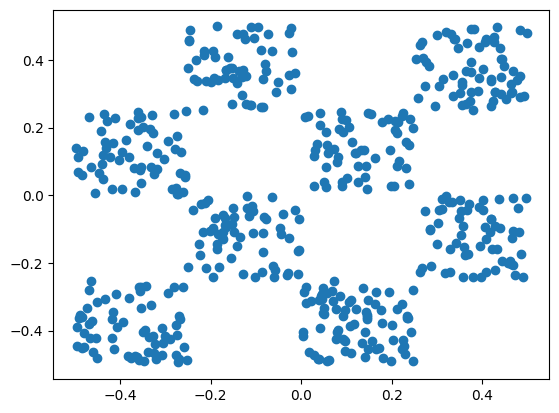

In [10]:
x = sample2d(data="checkerboard",batch_size=500)

plt.scatter(x[:,0],x[:,1])



Now that we have set up our data loader, we can construct a Typical VAE. The architectural backbone of our encoder and decoder will be a *DenseBlock*, which concatenates the output of each fully connected layer with its input.

In [11]:
import torch 
from torch import nn

class DenseBlock(nn.Module):
  def __init__(self, input_dim, growth, depth):
    super(DenseBlock,self).__init__()
    ops=[]
    for i in range(depth):
      ops.append(nn.Sequential(nn.utils.weight_norm(nn.Linear(input_dim+i*growth, growth)), nn.ReLU() ) )

    self.ops = nn.ModuleList(ops)

  def forward(self,x):
    for op in self.ops:
      y = op(x)
      x = torch.cat([x,y],1)
    return x


Note that we use Weight Norm as opposed to Batch Norm. The reasononing behind using Weight Norm is that Batch Norm introduces noise during training, which although tolerable for classification hurts our ability to precisely reconstruct the input. By using Weight Norm, any noise introduced in our VAE is counted towards the regularization loss. We can now construct our VAE architecture and define functions to performe inference. ```compute_negative_elbo``` computes the negative ELBO and will be used during training. ```importance_sampling``` approximates the exact negative log-likelihood and will be used during evaluation.

During training, we use a trick called the *free bits objective*. A problem with optimizing VAEs is that the latent space initially contains 0 information, so a lot of noise is applied to the space. This noise can send the optimization landscape into a bad local minima and cause swings in behavior depending on the random seed. To stabilize training, the free bits objective introduces a hyperparameter $\alpha$ such that the regularization loss is inactive for latent variables containing less than $\alpha$ bits of information. This allows the VAE to quickly learn to store $\alpha$ bits into each latent variable, after which training can stablely proceed with the standard negative ELBO objective. We want $\alpha$ to be high enough so that the VAE enters a stable regime of training but do not want $\alpha$ to be too high since the free bits objective is not the natural VAE objective. Moreover, if $\alpha$ is too high, then $q_\phi(\mathbf{z}|\mathbf{x})$ will very quickly have low variance, which may prevent exploration of the latent space. In our example we will use $\alpha=0.05$.

In [12]:
import torch
import math
import torch.nn.functional as F

class VAE(nn.Module):
  def __init__(self, latent_dim=2):
    super(VAE,self).__init__()
    #set up hyperparameters
    self.latent_dim = latent_dim
    growth=1024
    depth=6

    #define architecture
    encoder_dense = DenseBlock(2, growth,depth) 
    encoder_linear = nn.utils.weight_norm(nn.Linear(2+growth*depth, self.latent_dim*2))
    self.encoder = nn.Sequential(encoder_dense, encoder_linear)

    decoder_dense = DenseBlock(self.latent_dim, growth,depth) 
    decoder_linear = nn.utils.weight_norm(nn.Linear(self.latent_dim+growth*depth, 2*2))
    self.decoder = nn.Sequential(decoder_dense, decoder_linear)

  def encode(self,x):
    z_params = self.encoder(x)
    z_mu = z_params[:,:self.latent_dim]
    z_logvar = z_params[:,self.latent_dim:]
    return z_mu, z_logvar

  def decode(self,z):
    x_params = self.decoder(z)
    x_mu = x_params[:,:2]
    x_logvar = x_params[:,2:]
    return x_mu, x_logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    return mu + torch.cuda.FloatTensor(std.shape).normal_() * std

  def forward(self,x):
    z_mu, z_logvar = self.encode(x)
    z = self.reparameterize(z_mu, z_logvar)
    x_mu, x_logvar = self.decode(z)
    return x_mu,x_logvar, z_mu, z_logvar


  def compute_negative_elbo(self, x, freebits=0):
    x_mu, x_logvar, z_mu, z_logvar = self.forward(x)
    l_rec = -torch.sum(gaussian_log_prob(x, x_mu, x_logvar),1)
    l_reg = torch.sum(F.relu(self.compute_kld(z_mu, z_logvar)-freebits*math.log(2))+freebits*math.log(2),1)
    return l_rec + l_reg, l_rec, l_reg

  def compute_kld(self,z_mu, z_logvar):
    return 0.5*(z_mu**2 + torch.exp(z_logvar) - 1 - z_logvar)

  
  def importance_sampling(self, x, importance_samples=1):
    z_mu, z_logvar = self.encode(x)

    z_mu = z_mu.unsqueeze(1).repeat((1,importance_samples,1))
    z_mu = z_mu.reshape((-1, self.latent_dim))
    z_logvar = z_logvar.unsqueeze(1).repeat((1,importance_samples,1))
    z_logvar = z_logvar.reshape((-1, self.latent_dim))
    x = x.unsqueeze(1).repeat((1,importance_samples,1))
    x = x.reshape((-1,2))

    z = self.reparameterize(z_mu, z_logvar)
    x_mu, x_logvar = self.decode(z)
    x_mu = x_mu.reshape((-1,importance_samples,2))
    x_logvar = x_logvar.reshape((-1,importance_samples,2))

    x = x.reshape((-1,importance_samples,2))
    z = z.reshape((-1,importance_samples,self.latent_dim))
    z_mu = z_mu.reshape((-1,importance_samples,self.latent_dim))
    z_logvar = z_logvar.reshape((-1,importance_samples,self.latent_dim))

    logpxz = gaussian_log_prob(x, x_mu,x_logvar)
    logpz = gaussian_log_prob(z, torch.zeros(z.shape).cuda(), torch.zeros(z.shape).cuda())
    logqzx = gaussian_log_prob(z, z_mu, z_logvar)

    logprob = logpxz+logpz - logqzx
    logprob = torch.sum(logprob,2)
    logprob = log_mean_exp(logprob, 1)

    return -logprob

def gaussian_log_prob(z, mu, logvar):
  return -0.5*(math.log(2*math.pi) + logvar + (z-mu)**2/torch.exp(logvar))

def log_mean_exp(x,axis):
    m,_=torch.max(x,axis)
    m2,_ = torch.max(x,axis,keepdim=True)
    return m + torch.log(torch.mean(torch.exp(x-m2),axis))



We now have all the tools we need to train a VAE. We will sample 200 points each iteration and minimize the negative ELBO over the course of 60000 iterations. Each model should take roughly 20 minutes to train.

In [ ]:
import time

def s2hms(s):
  h = s//3600
  m = (s-h*3600)//60
  s = int(s-h*3600-m*60)
  return h,m,s

def print_progress(time, cur_iter, total_iter):
  h,m,s = s2hms(time)
  h2,m2,s2 = s2hms(time*total_iter/cur_iter - time)
  print('Time Elapsed: %d hours %d minutes %d seconds. Time Remaining: %d hours %d minutes %d seconds.'%(h,m,s,h2,m2,s2))


def train_vae(dataset, model=None, epochs=60000, print_freq=1000):
  if model is None:
    model = VAE().cuda()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5,
                                                          patience=epochs//20,
                                                          min_lr=1e-8, 
                                                          threshold_mode='abs')
  start=time.time()
  loss_ema=0
  best_ema =1e9
  for iteration in range(epochs): #train for 60k iterations
    data = torch.tensor(sample2d(dataset,40000)).float().cuda()
    neg_elbo, l_rec, l_reg = model.compute_negative_elbo(data,freebits=0.05)

    loss = torch.mean(l_reg + l_rec )/math.log(2)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_ema = 0.999*loss_ema + 0.001*loss
    data=None
    #scheduler.step(loss_ema)
    if iteration == int(epochs*0.6)  or iteration == int(epochs*0.7) or iteration == int(epochs*0.8) or iteration == int(epochs*0.9):
       for param_group in optimizer.param_groups:
           param_group['lr'] /= 2
    if iteration%print_freq == 0:
      with torch.no_grad():
        #print('Iteration %d. Loss: %f'%(iteration, loss))
        #neg_elbo, l_rec, l_reg = model.compute_negative_elbo(data,0)
        print('Iteration %d. EMA: %f ELBO: %f L_rec: %f L_reg: %f'%(iteration, loss_ema, torch.mean(neg_elbo)/math.log(2),torch.mean(l_rec)/math.log(2), torch.mean(l_reg)/math.log(2)))
        print_progress(time.time()-start, iteration+1, epochs)

  return model

In [15]:
model8g = train_vae('8gaussians',None,30,100) #should take ~20 minutes to train

/mnt/data/projects/shape-synthesis-v2/.venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

In [ ]:
modelc = train_vae('checkerboard',None,60000,100) #should take ~20 minutes to train

In [ ]:
model2s = train_vae('2spirals',None,60000,100) #should take ~20 minutes to train

We see that the reconstruction loss decreases as training progresses while the regularization loss increases.
Now that we have trained a model, we can evaluate it by comparing the negative log-likelihood with the ground-truth distribution and by plotting the density map of the model. The negative log-likelihood is approximated with importance sampling.

In [ ]:
def plot_density2d(model, max_prob, gt_prob, importance_samples=1):
    #code largely taken from https://github.com/nicola-decao/BNAF/blob/master/toy2d.py
    limit=0.5
    step=1/1024.0
    grid = torch.Tensor([[a, b] for a in np.arange(-limit, limit, step) for b in np.arange(-limit, limit, step)])
    grid_dataset = torch.utils.data.TensorDataset(grid.cuda())
    grid_data_loader = torch.utils.data.DataLoader(grid_dataset, batch_size=20000//importance_samples, shuffle=False)

    l=[]
    start=time.time()
    with torch.no_grad():
      for idx, (x_mb,) in enumerate(grid_data_loader):
        temp= model.importance_sampling(x_mb,importance_samples)
        l.append(torch.exp(-temp))
        if idx % 600 == 0 and idx>0:
          print_progress(time.time()-start, idx, len(grid_data_loader))
      prob = torch.cat(l, 0)
   
    prob = prob.view(int(2 * limit / step), int(2 * limit / step))
    prob[prob!=prob]=0 #set nan probabilities to 0

    prob+=1e-20
    prob = prob/1024/1024
    nll = - gt_prob * np.log(prob.cpu().data.numpy())/np.log(2)
    nll = np.sum(nll)
    print('Negative Log Likelihood' , nll-20)

    prob /= torch.sum(prob)
    prob = prob.clamp(max=max_prob)

    prob = prob.cpu().data.numpy()

    fig = plt.figure(figsize=(18, 18))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.axis('off')
    ax1.imshow(gt_prob, extent=(-limit, limit, -limit, limit))

    ax2 = fig.add_subplot(1,2,2)
    ax2.axis('off')
    ax2.imshow(prob, extent=(-limit, limit, -limit, limit))

    fig.tight_layout()

Let us first quickly evaluate our models using 1 importance sample.

In [ ]:
plot_density2d(model8g, max_prob8g,prob8g, 1)


In [ ]:
plot_density2d(modelc, max_probc,probc, 1)


In [ ]:
plot_density2d(model2s, max_prob2s,prob2s, 1)

When we use only 1 importance sample, then the result is essentially the negative ELBO. We will now better approximate the likelihood by taking 250 importance samples, which will take 250 times longer. This provides a more accurate evaluation of the model performance and gives us an idea of how tight of a bound the negative ELBO is.

In [ ]:
plot_density2d(model8g, max_prob8g,prob8g, 250) #should take around 20 minutes

In [ ]:
plot_density2d(modelc, max_probc,probc, 250) #should take around 20 minutes

In [ ]:
plot_density2d(model2s, max_prob2s,prob2s, 250) #should take around 20 minutes

We can also qualitatively understand the unsupervised representation learning abilities of the VAE by visualizing the correspondence between the latent space and the color maps of the ground truth distribution. We also print out the probability mass of low-density ``dark pixels" to quantitatively evaluate how ``filled" the latent space is.


In [ ]:
def visualize_latent(model, colormap_gt):
    limit=2
    step=1/256.0
    grid = torch.Tensor([[a, b] for a in np.arange(-limit, limit, step) for b in np.arange(-limit, limit, step)])
    grid_dataset = torch.utils.data.TensorDataset(grid.cuda())
    grid_data_loader = torch.utils.data.DataLoader(grid_dataset, batch_size=20000, shuffle=False)
    colormap_gt = colormap_gt.reshape((1024*1024,3))
    l = []
    with torch.no_grad():
      for z ,in grid_data_loader:
        x,_ = model.decode(z) #find the value that each latent vector maps to
        l.append(x)
    x = torch.cat(l,0)
    x=(x*1024+512).long() #find the corresponding pixel in the color map 
    x[x<0]=0
    x[x>1023]=1023
    y = x[:,0]*1024+x[:,1]
    y = y.reshape((-1,1)).repeat((1,3))

    colormap_pred = torch.gather(torch.tensor(colormap_gt).cuda(), 0,y)
    pz = torch.exp(torch.sum(gaussian_log_prob(grid.cuda(), torch.zeros(grid.shape).cuda(), torch.zeros(grid.shape).cuda()),-1))
    pz/=torch.sum(pz)
    color = col.rgb_to_hsv(colormap_pred.cpu().numpy())[:,2]
    print('Dark Pixels', torch.sum(pz*(torch.tensor(color).cuda()<0.01).float()).item())


    colormap_pred = colormap_pred.reshape((1024,1024,3)).cpu().data.numpy()
    colormap_gt = colormap_gt.reshape((1024,1024,3))




    fig = plt.figure(figsize=(18, 18))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.axis('off')
    ax1.imshow(colormap_gt, extent=(-0.5, 0.5, -0.5, 0.5))

    ax2 = fig.add_subplot(1,2,2)
    ax2.axis('off')
    ax2.imshow(colormap_pred, extent=(-limit, limit, -limit, limit))

    fig.tight_layout()



In [ ]:
visualize_latent(model8g,color8g)

In [ ]:
visualize_latent(modelc,colorc)

In [ ]:
visualize_latent(model2s,color2s)

##IWAEs
We now switch out the negative ELBO for an approximation of the negative log likelihood using importance sampling.

In [ ]:
def train_iwae(dataset, model=None, epochs=60000, print_freq=1000):
  if model is None:
    model = VAE().cuda()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5,
                                                           patience=epochs/20,
                                                           min_lr=1e-8, verbose=True,
                                                           threshold_mode='abs')
  start=time.time()
  loss_ema=0
  for iteration in range(epochs): #train for 60k iterations
    data = torch.tensor(sample2d(dataset,200)).float().cuda()
    nll = model.importance_sampling(data,10)
    loss = torch.mean(nll)/math.log(2)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_ema = 0.999*loss_ema + 0.001*loss
    #scheduler.step(loss_ema)
    if iteration == int(epochs*0.6)  or iteration == int(epochs*0.7) or iteration == int(epochs*0.8) or iteration == int(epochs*0.9):
       for param_group in optimizer.param_groups:
           param_group['lr'] /= 2
    if iteration%print_freq == 0:
      with torch.no_grad():
        print('Iteration %d. Loss: %f'%(iteration, loss))
        neg_elbo, l_rec, l_reg = model.compute_negative_elbo(data,0)
        print('Iteration %d. EMA: %f ELBO: %f L_rec: %f L_reg: %f'%(iteration, loss_ema, torch.mean(neg_elbo)/math.log(2),torch.mean(l_rec)/math.log(2), torch.mean(l_reg)/math.log(2)))
        print_progress(time.time()-start, iteration+1, epochs)

  return model

In [ ]:
model8g_iwae = train_iwae('8gaussians', None, 30000,400) #should take ~20 minutes to train

In [ ]:
modelc_iwae = train_iwae('checkerboard', None, 30000,400) #should take ~20 minutes to train

In [ ]:
model2s_iwae = train_iwae('2spirals', None, 30000,400) #should take ~20 minutes to train

We see that compared to a Typical VAE, $D_{KL}(q_\phi(\mathbf{z}|\mathbf{x}), p_\theta(\mathbf{z}))$ is lower, indicating that the variance of $q_\phi(\mathbf{z}|\mathbf{x})$ is higher than in a VAE. We now evaluate our model and check how accurate of an approximation our objective was to the true negative log likelihood.

In [ ]:
plot_density2d(model8g_iwae, max_prob8g,prob8g ,10)

In [ ]:
plot_density2d(modelc_iwae, max_probc,probc ,10)

In [ ]:
plot_density2d(model2s_iwae, max_prob2s,prob2s ,10)

In [ ]:
plot_density2d(model8g_iwae, max_prob8g,prob8g ,250) #should take ~20 minutes

In [ ]:
plot_density2d(modelc_iwae, max_probc,probc ,250) #should take ~20 minutes

In [ ]:
plot_density2d(model2s_iwae, max_prob2s,prob2s ,250) #should take ~20 minutes

We now visualize the latent space of IWAE. We see that compared to Typical VAEs much less of the latent space is mapped to low-density inputs.

In [ ]:
visualize_latent(model8g_iwae,color8g)

In [ ]:
visualize_latent(modelc_iwae,colorc)

In [ ]:
visualize_latent(model2s_iwae,color2s)

In [ ]:
print('Marginal KL',calc_marginal_kl(model8g_iwae, '8gaussians')) #should take ~1 minute

In [ ]:
print('Marginal KL',calc_marginal_kl(modelc_iwae, 'checkerboard'))

In [ ]:
print('Marginal KL',calc_marginal_kl(model2s_iwae, '2spirals'))